## Importing Libraries

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

In [9]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"

### Showcase Run

In [24]:
unop_univariate_baseline_true = np.squeeze(np.load(DATASETS_FOLDER+"unop_univariate_baseline_true_y.npy"))
unop_univariate_baseline_predicted = np.load(DATASETS_FOLDER+"unop_univariate_baseline_predicted_y.npy")

unop_univariate_multiOne_true = np.squeeze(np.load(DATASETS_FOLDER+"unop_univariate_multiOne_true_y.npy"))
unop_univariate_multiOne_predicted = np.load(DATASETS_FOLDER+"unop_univariate_multiOne_predicted_y.npy")

In [25]:
unop_univariate_baseline_residuals = unop_univariate_baseline_true - unop_univariate_baseline_predicted
unop_univariate_baseline_residuals = np.sum(unop_univariate_baseline_residuals, axis=1)

unop_univariate_multiOne_residuals = unop_univariate_multiOne_true - unop_univariate_multiOne_predicted
unop_univariate_multiOne_residuals = np.sum(unop_univariate_multiOne_residuals, axis=1)

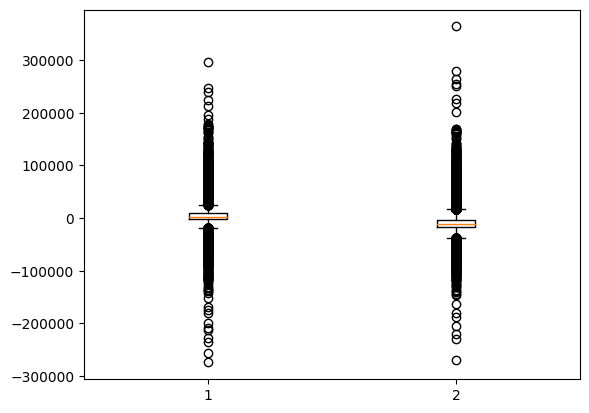

In [28]:
unop_univariate_baseline_boxplot = plt.boxplot([unop_univariate_baseline_residuals, unop_univariate_multiOne_residuals])

In [31]:
unop_univariate_baseline_var = np.var(unop_univariate_baseline_residuals)
print("Baseline Var", unop_univariate_baseline_var)
unop_univariate_multiOne_var = np.var(unop_univariate_multiOne_residuals)
print("MultiOne Var", unop_univariate_multiOne_var)

Baseline Var 424398433.5625493
MultiOne Var 431965879.13404727


## Defining Analysis Functions

In [1]:
def import_data(model_name="univariate_baseline"):
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    return true, predicted

In [2]:
def compute_residuals(true, pred):
    residuals = np.sum(true-pred, axis=1)
    return residuals

In [3]:
def generate_boxplot(datasets=[],title="DEFAULT", ylab="Download Bitrate",xlab=[],
                      output_folder="C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Images/"):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylab)
    ax.boxplot(datasets, labels=xlab)
    plt.savefig(output_folder+title+".png", dpi=320)

In [4]:
def get_variance(data):
    return np.var(data)

In [5]:
def get_std(data):
    return np.std(data)

In [29]:
def carry_out_analysis(prefix="unop_univariate", title_prefix="Unoptimised Univariate"):
    for test_set in ["", "low", "medium", "high"]:
        all_residuals = []
        xlabels = []
        table = PrettyTable(["Model", "Variance", "Standard Dev"])
        for model in ["baseline", "multiOne", "multiAll"]:
            if not test_set:
                true, pred = import_data(prefix+"_{}".format(model))
            else:
                true, pred = import_data(prefix+"_{}_{}".format(model, test_set))
            print("\n\n\nHERE", prefix+"_{}_{}".format(model, test_set))
            residuals = compute_residuals(true, pred)
            all_residuals.append(residuals)
            xlabels.append(model)
            var = get_variance(residuals)
            std = get_std(residuals)
            table.add_row([model, var, std])
        box_title = title_prefix + " {}".format(test_set.capitalize())
        if not test_set:
            box_title = title_prefix
        generate_boxplot(all_residuals, title=box_title, xlab=xlabels)
        print(box_title)
        print(table)
        print("\n\n")




HERE unop_all_network_baseline_



HERE unop_all_network_multiOne_



HERE unop_all_network_multiAll_
Unoptimised All Network Features
+----------+--------------------+--------------------+
|  Model   |      Variance      |    Standard Dev    |
+----------+--------------------+--------------------+
| baseline | 423973385.06581646 | 20590.61400409945  |
| multiOne | 457492010.87410796 | 21389.062879754878 |
| multiAll | 442775661.3945224  | 21042.235180572487 |
+----------+--------------------+--------------------+






HERE unop_all_network_baseline_low


ValueError: operands could not be broadcast together with shapes (27089,5) (4417,5) 

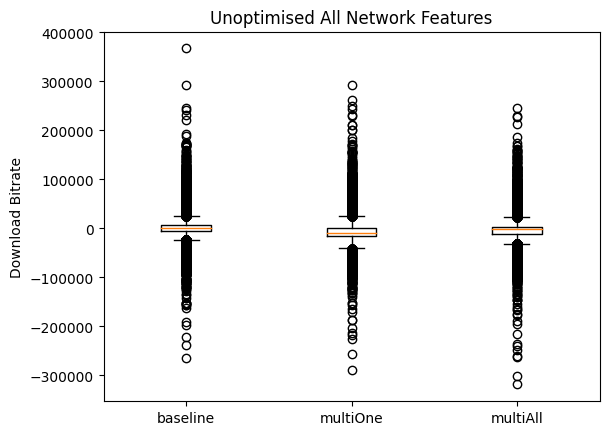

In [30]:
carry_out_analysis(prefix="unop_all_network", title_prefix="Unoptimised All Network Features")

In [19]:
true, pred = import_data("unop_all_network_multiAll")

In [20]:
print(true[0])
print(pred[0])

[11904. 20785.  8392.  9505. 11575.]
[14333.51050424 14361.79532754 14474.07008678 14112.93280113
 14543.98817072]
